In [1]:
import string
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from plot_utils import plot_mean_feature_per_well


In [2]:
feature = "Cells_AreaShape_Compactness"

In [3]:
# profiles = pd.read_parquet("output/subset_profiles_cc_well_corrected.parquet")
profiles = pd.read_parquet("output/subset_profiles_cc_corrected.parquet")
profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_01_256,Nuclei_Texture_InfoMeas1_AGP_5_02_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,0.843619,0.076587,0.320472,-0.385526,0.190299,0.455335,0.509991,-1.019452,-0.727796,-0.842709
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-0.553261,-1.089581,-0.339225,-1.516519,-0.441941,-0.130427,-0.575876,0.593761,0.509689,-0.214481
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-0.234735,-0.754526,0.077711,-0.321833,0.405425,0.628227,0.367096,0.264792,-0.726009,-0.754048
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,0.015636,-0.494281,-0.287685,-0.627869,-0.710446,-0.636987,-0.199217,-0.135424,-0.290031,0.329685
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-0.037931,-0.722416,-0.448440,-1.166354,-1.939870,-1.752882,-0.387810,-0.074516,0.047316,1.303088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-2.711810,-3.969504,-0.809101,-2.974631,-2.787255,-0.704379,0.198949,2.074013,0.223548,-0.531547
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.077549,-3.094378,-0.711043,-2.103474,-1.919203,-0.485693,0.300183,1.795833,-0.029274,-0.503630
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.488542,-3.648642,-0.653825,-2.628841,-2.837851,-0.915129,0.115583,2.372840,0.351046,0.082553
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.968013,-4.203432,-0.806062,-2.797244,-2.399043,-0.965500,0.605841,2.384713,0.194849,0.017739


### Visualize feature means by well position with colors range across mean values

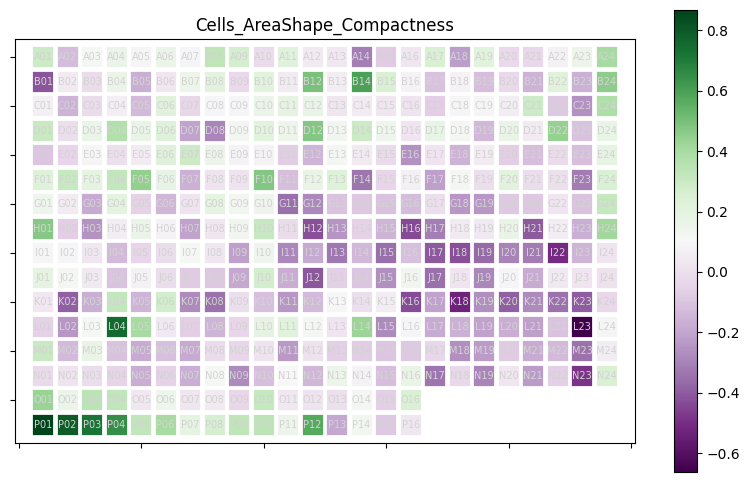

In [4]:
plot_mean_feature_per_well(profiles, feature)

### Visualize feature means by well position with colors range across unaggregated raw values

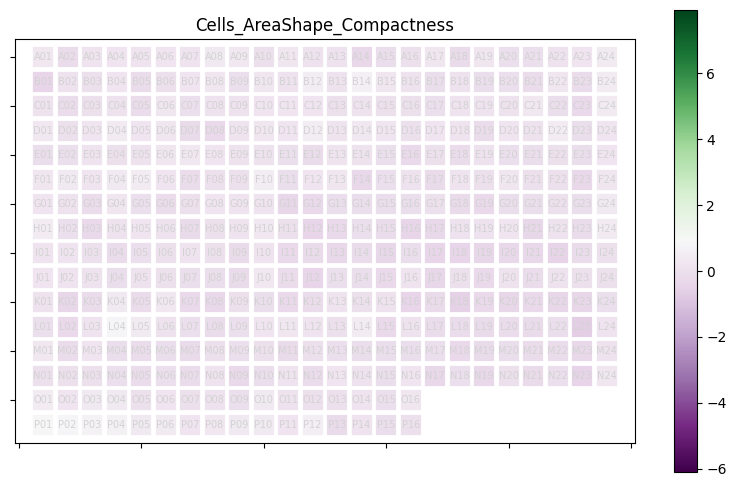

In [5]:
plot_mean_feature_per_well(profiles, feature, colormap_range=(profiles[feature].min(), profiles[feature].max()))